In 2017, I downloaded [Headspace](www.headspace.com) and started meditating. I found it so beneficial that I decided to try for a one-year streak: meditating every day for a year. About a year ago, I successfully finished my yearlong streak. This blog post is very delayed, but I've been meaning to analyze this data since then. And who knows, maybe it'll even motivate me to get back into meditating regularly!

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# The data

The Headspace app shows you all of your previous meditations in visual format, so I figured there would be a way to get the data. I couldn't find anything official, so I emailed customer support and asked for my data last August. After a bit of back-and-forth, they sent it to me as a `.csv` file.

For some reason, each line in the file is surrounded by quotation marks so I'll need to go in a clean it up a bit manually:

In [8]:
fraw = "Claire's History - Sheet1_headspace.csv"
fclean = 'headspace_clean.csv'

# Manually read in the file
with open(fraw, 'r') as f:
    lines = f.readlines()

# Strip all lines of newline and quotation markers    
lines = [l.strip().strip('"') for l in lines]

# Write a new file
with open(fclean, 'w') as f:
    f.write('\n'.join(lines))

Now we can just read in the file through a normal call to pandas:

In [26]:
df = pd.read_csv(fclean)
df.head()

,Headspace UserId,Pack Category,Pack Name,Session Name,Completion Date,Completion Platform
0,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 1,2017-01-26 13:12:36,NaN
1,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 2,2017-01-27 13:24:42,NaN
2,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 3,2017-01-29 14:59:06,NaN
3,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 4,2017-01-31 12:56:09,NaN
4,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 5,2017-02-03 13:00:05,NaN


Let's first try to understand what columns there are here. Most are pretty self-explanatory, but let's look at a few of the more surprising ones to see what unique values they contain:

In [27]:
for col in ['Headspace UserId', 'Pack Category', 'Completion Platform']:
    # Print the column name and all its unique values.
    # Drop NaN's so it doesn't break the print statement
    print(col + ': ' + ', '.join(df[col].dropna().unique()))

Headspace UserId: HSUSER_RQZSRPKAAWOWY30R
Pack Category: PACK_GROUP, DISCOVER_SINGLES, MINIS, EVERYDAY_HEADSPACE
Completion Platform: ANDROID, DESKTOP, IOS


Okay, so this is the data I'm working with:

- **Headspace UserID**: this has one value, my own User ID. This is how they pulled the data.
- **Pack Category**: Headspace has different types of meditations: singles and packs. Singles are stand-alone meditations, whereas packs are part of a series all focused on a similar topic.
- **Pack Name**: this is just the name of the pack I did
- **Session Name**: indicates which session of the pack I did. In the case of a single, I think it will be the name of the meditation session itself.
- **Completion Date**: day that I completed the meditation
- **Completion Platform**: looks like it also tracks which sort of platform I meditated through. I imagine most will be my phone (which is an Android), but I also had to get creative at times when my phone wasn't available so I didn't break my streak.

In order to use a lot of the pandas querying functions, I need to change these column labels so they don't have spaces. 

In [29]:
# The inner list comprehension just converts each string in 
# the split list to lower, and then re-joins them with an
# underscore.
df.columns = ['_'.join([j.lower() for j in i.split(' ')]) for i in df.columns]
df.columns

Index([u'headspace_userid', u'pack_category', u'pack_name', u'session_name',
       u'completion_date', u'completion_platform'],
      dtype='object')

There's one column that's missing, which is the length of the meditation. Sessions that are part of a pack are 10 minutes each; minis are either 1, 2, or 3 minutes; singles are available in 3, 5, and 10 minute sessions; and the everyday headspace sessions are similarly available in 3, 5, and 10 minutes. I think I can safely assume that all the Everyday Headspace sessions were 5 minutes (I tended to do these when I was lazy or didn't have time for a full ten minute meditation) and that all the minis were 3 minutes (though I do think some were shorter). The singles are more varied though, let's see what types of sessions we have there:

In [35]:
df.query('pack_category == "DISCOVER_SINGLES"')['session_name'].unique()

array(['Sleeping', 'SOS 4', 'Guided', 'Commuting', 'End of Day', 'Reset',
       'Recovery', 'Waking Up', 'Taking a Break', 'Stressed',
       'Early Mornings', 'Vacation', 'For the Weekend', 'Sound: snooze',
       'Fear of Flying', 'In Your Home', 'Presentations',
       'Parks & Nature', 'Motivation', 'Interviews', 'Losing Your Temper',
       'Frustrated', 'Under the Weather', 'Falling Back to Sleep',
       'Eating'], dtype=object)

Hm, I recognize these having a variety of session lengths. Let's code up their lengths based on what I remember.

In [36]:
# Singles that I tended to do for five minutes
five_min = ['SOS 4', 'Reset', 'Taking a Break',
            'Early Mornings', 'Vacation', 'For the Weekend', 'Sound: snooze',
            'Presentations', 'Parks & Nature', 'Interviews', 'Losing Your Temper',
            'Frustrated']
# Singles that I tended to do for ten minutes
ten_min = [i for i in df.query('pack_category == "DISCOVER_SINGLES"')['session_name'].unique()
           if i not in five_min]

In [37]:
# Add a new column with session length

# All packs were 10 min
df.loc[df.query('pack_category == "PACK_GROUP"').index, 'session_length'] = 10
# All minis were 3 min
df.loc[df.query('pack_category == "MINIS"').index, 'session_length'] = 3
# All everyday headspace were 5 min
df.loc[df.query('pack_category == "EVERYDAY_HEADSPACE"').index, 'session_length'] = 3
# The singles are mixed
df.loc[
    df.query('pack_category == "DISCOVER_SINGLES"').query('session_name == @five_min').index,
    'session_length'
    ] = 5
df.loc[
    df.query('pack_category == "DISCOVER_SINGLES"').query('session_name == @ten_min').index,
    'session_length'
    ] = 10

In [38]:
df.head()

,headspace_userid,pack_category,pack_name,session_name,completion_date,completion_platform,session_length
0,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 1,2017-01-26 13:12:36,NaN,10.0
1,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 2,2017-01-27 13:24:42,NaN,10.0
2,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 3,2017-01-29 14:59:06,NaN,10.0
3,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 4,2017-01-31 12:56:09,NaN,10.0
4,HSUSER_RQZSRPKAAWOWY30R,PACK_GROUP,Basics,Session 5,2017-02-03 13:00:05,NaN,10.0


# Yearlong streak

First, I'll investigate my yearlong streak. I'll first plot some broad overviews of the year: my cumulative meditation time, the time of day I completed each pack and the type of pack.

First, I have to find the day I started my streak.

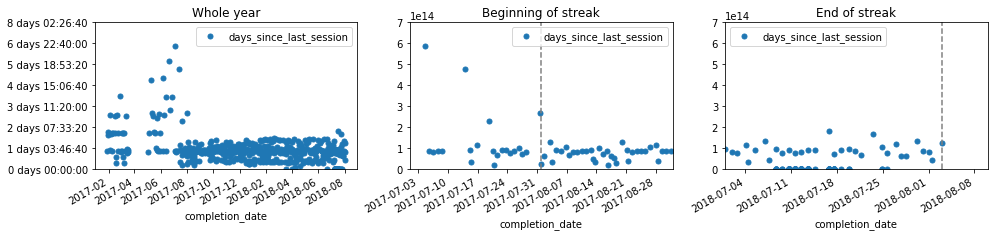

In [144]:
# Convert completion date column to DateTime type
df['completion_date'] = df['completion_date'].apply(lambda x: pd.to_datetime(x))

# Calculate the difference between consecutive dates
df['days_since_last_session'] = df['completion_date'].diff()

# Plot
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
df.plot(kind='line', style='.', markersize=10, ax=ax[0],
        x='completion_date', y='days_since_last_session')

# Zoom in to remove the one outlier, which was a 45-day dry streak
ax[0].set_ylim([0, 0.7e15])

# Convert the integer timedelta's back into human-readable strings
_ = ax[0].set_yticklabels([pd.to_timedelta(i) for i in ax[0].get_yticks()])
ax[0].set_title('Whole year')

# For the second axis, zoom into before August 2017
df.plot(kind='line', style='.', markersize=10, ax=ax[1],
        x='completion_date', y='days_since_last_session')
ax[1].set_ylim([0, 0.7e15])
ax[1].set_xlim([pd.to_datetime('July 2017'), pd.to_datetime('September 2017')])

# Looks like I started on August 1, 2017.
ax[1].axvline(x=pd.to_datetime('August 1, 2017'), linestyle='--', c='gray')
ax[1].set_title('Beginning of streak')

# For the third axis, zoom into the end of the streak
df.plot(kind='line', style='.', markersize=10, ax=ax[2],
        x='completion_date', y='days_since_last_session')
ax[2].set_ylim([0, 0.7e15])
ax[2].set_xlim([pd.to_datetime('July 2018'), pd.to_datetime('August 10, 2018')])

ax[2].axvline(x=pd.to_datetime('August 3, 2018'), linestyle='--', c='gray')
_ = ax[2].set_title('End of streak')

It looks like I started my streak on August 1, 2017 and ended it on August 3, 2018. When we look at just the streak, we'll subset this part of the data for those analyses. There isn't any data past the end of the streak, so we can just grab anything after August 1, 2017.

Also, it seems that there were quite a few sessions in July 2018 where there was no time between sessions. I vaguely remember having some issues with my app when I was traveling an offline, so let's just remove those.

In [154]:
# Remove any sessions with zero time between sessions
df = df.query('days_since_last_session_int != 0')

# Prepare a dataframe with just the yearlong streak data
dfyear = df.loc[df['completion_date'] > pd.to_datetime('August 1, 2017')]

Now, let's plot the cumulative time I spent meditating through this streak.

Text(0.5,0,'')

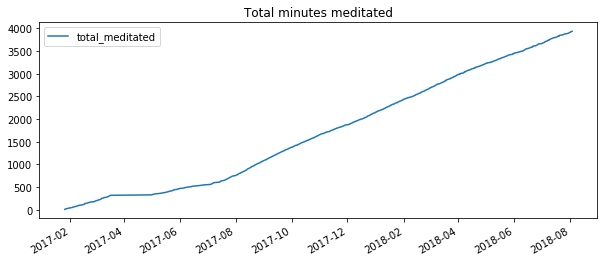

In [157]:
# Add column with total time meditated
df['total_meditated'] = df['session_length'].cumsum()

# Plot cumulative time spent meditating
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(kind='line', x='completion_date', y='total_meditated', ax=ax)
ax.set_title('Total minutes meditated')
ax.set_xlabel('')

Damn that's beautiful. One year of steadily increasing meditation time -- so cool to see it so plainly. 

Next question: what time of day did I tend to meditate? To answer this, I'll have to extract just the time from the completion date column.

In [170]:
pd.to_datetime('10 pm August 1, 2018').hour

22

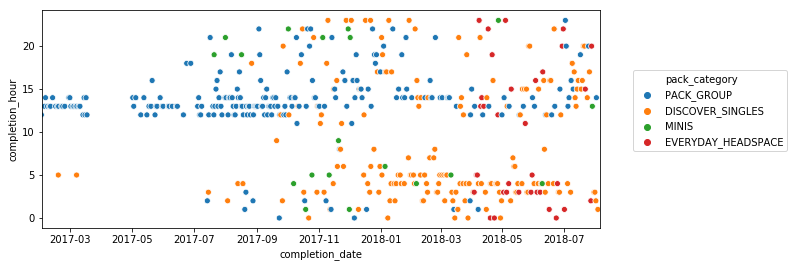

In [180]:
# Make new column with the hour of the day
df['completion_hour'] = df['completion_date'].apply(lambda x: x.hour)

# Plot, colored by pack category
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=df, x='completion_date', y='completion_hour', 
                     hue='pack_category', ax=ax)
ax.set_xlim([pd.to_datetime('February 2017'), pd.to_datetime('August 5, 2018')])
ax.legend(bbox_to_anchor=(1.05, 0.75))

Weird, there seems to be _a lot_ of meditations that I did in the middle of the night. I need to go back and check my calendar, but I'm assuming these will be during times when I was traveling and when my phone was offline. While Headspace does work quite well offline, I'm guessing the times it recorded weren't corrected for the time difference. Not sure, but it does make sense since most of these are not packs but rather singles, likely ones that I pre-downloaded. 

There are a couple of other explanations for the middle-of-the-night meditations. The first is relatively innocuous: I really love the Sleep pack, and often used it to fall asleep. I remember a few times being really stressed and/or over-caffeinted, working quite late and then using the Sleep pack to immediately zonk out to sleep. Such a helpful tool. In fact, meditating helped my sleep significantly: I used to be _really_ sensitive to caffeine, unable to fall asleep at night if I'd had coffee past noon. But with the Sleep pack, I could drink coffee up to a reasonable time and still be able to fall asleep. So wonderful, thanks for enabling my addiction Headspace! :D

I'll re-plot this, just looking at "reasonable" times. 

Okay, fine, you got me: there's _another_ reason for the late night meditations. I definitely had a couple of drunk 2 am meditations for the sole purpose of keeping my streak going! Not sure if I was always in the right faculty of mind for it to count but... it's the thought that counts? ;)

In [190]:
pd.to_datetime?

In [193]:
[pd.to_datetime({'hour': i.hour, 'minute': i.minute}) for i in df['completion_date']]

AttributeError: 'Series' object has no attribute 'hour'

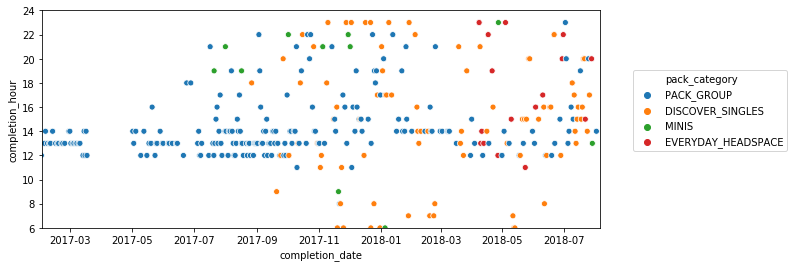

In [186]:
# Plot, colored by pack category
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=df, x='completion_date', y='completion_hour', 
                     hue='pack_category', ax=ax)
ax.set_xlim([pd.to_datetime('February 2017'), pd.to_datetime('August 5, 2018')])
ax.set_ylim([6, 24])
ax.legend(bbox_to_anchor=(1.05, 0.75))

Wow, interesting! Before my streak started, I was _super_ consistent and did a pack session around midday. Then I got tired of this consistency and had a monthlong break. When I came back, I continued my consistent schedule for a month or two, and then diversified. Until the end of that year, I still fairly consistently came back to the midday pack meditation, but by 2018 I much more rarely did that. That's when the singles started taking over and you also start to see a lot more of the Everyday Headspace sessions.

I'm surprised that I didn't have more morning sessions -- I was under the impression that I'd often end up choosing between meditating at home before leaving (and often missing my bus), or catching my bus and meditating at work. Seems like I chose to meditate at work (around or after 11 am) much more often than I realized...

It looks like for the first four months, I was actually _super consistent_, meditating around midday and doing a pack session. You can tell that I got a lot less consistent after that, with times ranging from 

Some questions I'll want to ask:

- yearlong streak
    - did I really meditate every day? Headspace gives you a bit more than 24 hours to meditate before it resets your streak (link to the help page), and there were a few times I definitely cut it close. Let's see if I can find those in this data.
    - is there any pattern to my meditation before I started on the yearlong streak? i.e. did my streaks get progressively longer, or did I just decide to do it cold turkey?

- daily habit
    - was there a pattern to when I would meditate? How about in the non-streak time vs. the streak-time?
    - how did the time I meditate for each day evolve over the year? (i.e. 10 vs 5 minutes)
    - how often did I meditate more than once a day?

- meditation types
    - what were my favorite meditations, and how did that evolve over time? My hypothesis is that I started doing a lot of packs, but then switched to doing many singles interspersed with packs. 
    - how good was I at following through on packs? i.e. how long was my longest pack streak (doing consecutive pack sessoins without a single in between)
    - how did this change once the "everyday headspace" singles were introduced? I really loved these.